<a href="https://colab.research.google.com/github/dimitramuni/732A92-Text-Mining/blob/main/DistilBERT_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#using data from http://snap.stanford.edu/data/web-FineFoods.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [ ]:
#Data Cleaning
with open('/content/drive/MyDrive/Finefood/finefood.txt', encoding='latin-1') as source:
    f=source.read()
    raw_list=f.split('\n\n')
    #creating a dictionary with productID and userID as keys 
    #{('productID','userID'):('profileName','helpfuness','score','time','summary','text')}
    
    my_dict={}
    for row in raw_list:
      #disregaring the row which has more than 8 features
      if(len(row.split('\n'))==8):
        my_dict[row.split('\n')[0].split(': ')[1],row.split('\n')[1].split(': ')[1]]\
        =row.split('\n')[2].split(': ')[1],row.split('\n')[3].split(': ')[1],row.\
        split('\n')[4].split(': ')[1],row.split('\n')[5].split(': ')[1],row.split('\n')[6].\
        split(': ')[1],row.split('\n')[7].split(': ')[1]  
      


    

In [ ]:
FF_k=pd.DataFrame(my_dict.keys(),columns=['productID','userID'])
FF_v=pd.DataFrame.from_dict(my_dict,orient='index',columns=['profileName','helpfulness','score','time','summary','text']).reset_index()
FineFoods=pd.merge(FF_k,FF_v,left_index=True, right_index=True).drop(columns='index')
FineFoods['score']=FineFoods['score'].astype('float')
FineFoods[['summary','text']]=FineFoods[['summary','text']].astype('string')
FineFoods.head()
FineFoods.dtypes


productID       object
userID          object
profileName     object
helpfulness     object
score          float64
time            object
summary         string
text            string
dtype: object

In [ ]:
FineFoods_Reduced=FineFoods.loc[FineFoods.score!=3].copy()
FineFoods_Reduced['sentiment']=np.select([FineFoods_Reduced.score>3,FineFoods_Reduced.score<3],['positive','negative'])
FineFoods_Reduced['sentiment_binary']=np.select([FineFoods_Reduced.score>3,FineFoods_Reduced.score<3],[1,0])

FineFoods_Reduced.head()
#https://newbedev.com/how-to-use-if-else-in-pandas-dataframe-code-example

,productID,userID,profileName,helpfulness,score,time,summary,text,sentiment,sentiment_binary
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative,0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive,1
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive,1


In [ ]:
FineFoods_Reduced['sentiment_binary'].value_counts()

1    437635
0     81135
Name: sentiment_binary, dtype: int64

In [ ]:
print('Total number of data points:', FineFoods_Reduced.shape[0])

Total number of data points: 518770


In [ ]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(FineFoods_Reduced['text'],FineFoods_Reduced['sentiment_binary'],test_size=0.15, stratify=FineFoods_Reduced['sentiment_binary'])


In [ ]:
ytrain.value_counts()

1    371989
0     68965
Name: sentiment_binary, dtype: int64

In [ ]:
ytest.value_counts()

1    65646
0    12170
Name: sentiment_binary, dtype: int64

In [ ]:
ytest=np.array(ytest).reshape((-1,1))

# Undersampling Imbalanced Dataset

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

Xtemp=np.array(Xtrain).reshape(-1,1)
ytemp=np.array(ytrain).reshape(-1,1)
RuSampler=RandomUnderSampler(random_state=1728)
Xtr,ytr=RuSampler.fit_resample(Xtemp,ytemp)
ytr=np.array(ytr).reshape((-1,1))


In [ ]:
pd.Series(ytr.flatten()).value_counts()

0    68965
1    68965
dtype: int64

In [ ]:
ntrain=Xtr.shape[0]
ntrain

137930

In [ ]:
df_balanced=pd.DataFrame(data={'text':Xtr.flatten(),'sentiment':ytr.flatten()})
df_balanced_shuffled= df_balanced.sample(frac=1,random_state=1728).reset_index().drop(columns='index')

In [ ]:
df_balanced_shuffled.shape[0]

137930

## Training + validation

Out of 137,930 training samples, we further utilise only 20% of the data for small BERT training, later on when we identify the tuned model, we re-train on entire training dataset.

In [ ]:
# by default this will run on 20% of the training dataset
use_entire=False # change to True for using enire dataset
if(use_entire==False):
  n_train=int(np.floor(df_balanced_shuffled.shape[0]*0.2))
else:
  n_train=df_balanced_shuffled.shape[0]

df_balanced_shuffled_dataset=df_balanced_shuffled.iloc[:n_train]
print(df_balanced_shuffled_dataset.shape[0])
#Further 75-25 Training Validation Split
train_len=int(np.floor(n_train*0.75))

X_tr=df_balanced_shuffled_dataset['text'].iloc[:train_len].copy()
y_tr=df_balanced_shuffled_dataset['sentiment'].iloc[:train_len].copy()

X_val=df_balanced_shuffled_dataset['text'].iloc[train_len:].copy()
y_val=df_balanced_shuffled_dataset['sentiment'].iloc[train_len:].copy()

27586


In [ ]:
df_balanced_shuffled_dataset['sentiment'].iloc[1:n_train].value_counts()

0    13827
1    13758
Name: sentiment, dtype: int64

In [ ]:
y_tr.value_counts()

0    10396
1    10293
Name: sentiment, dtype: int64

In [ ]:
y_val.value_counts()

1    3465
0    3432
Name: sentiment, dtype: int64

# DistilBERT 

In [ ]:
!pip install -q -U "tensorflow==2.9.0"
!pip install -q -U "tensorflow-text==2.9.0"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.11.3 requires tensorflow~=2.11.0, but you have tensorflow 2.9.0 which is incompatible.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.11.3 requires tensorflow~=2.11.0, but you have tensorflow 2.9.0 which is incompatible.
tf-models-official 2.11.3 requires tensorflow-text~=2.11.0, but you have tensorflow-text 2.9.0 which is incompatible.


In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from sklearn.metrics import classification_report

In [ ]:
#Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1")


text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text input')
pre_processed_text=preprocessor(text_input)
encoded_text=encoder(pre_processed_text)

output_dropout_layer=tf.keras.layers.Dropout(0.1, name='Dropout_Layer')(encoded_text['pooled_output'])
output_dense_layer=tf.keras.layers.Dense(1,activation='sigmoid',name='Dense_Layer')(output_dropout_layer)
model=tf.keras.Model(inputs=[text_input],outputs=[output_dense_layer])


In [ ]:
def performance_plot(history):
  train_loss=history.history['loss']
  val_loss=history.history['val_loss']
  train_acc=history.history['binary_accuracy']
  val_acc=history.history['val_binary_accuracy']
  xvar=range(1,epochs+1)

  plt.figure(figsize=(12,8))
  plt.subplot(2,1,1)
  plt.plot(xvar,train_acc)
  plt.plot(xvar,val_acc)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(['Training Accuracy','Validation Accuracy'])

  plt.subplot(2,1,2)
  plt.plot(xvar,train_loss)
  plt.plot(xvar,val_loss)
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend(['Training Loss','Validation Loss'])


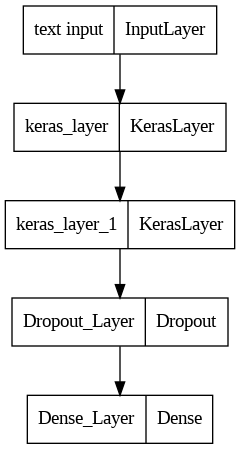

In [ ]:
tf.keras.utils.plot_model(model)

## Experiment:1

Basic, without optimisation, lr=0.01


In [ ]:
epochs=10
batch_size=256
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

print(model.summary())
history1=model.fit(X_tr,y_tr,epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val,y_val),
                    verbose=1)
#print('\n Training Evaluation')
#print(model.evaluate(Xtr,ytr))
print('\n Test Evaluation')
print(model.evaluate(Xtest,ytest))
test_prediction=model.predict(Xtest)
predicted_test=[1 if x>0.5 else 0 for x in test_prediction.flatten()]
print(classification_report(ytest,predicted_test))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                          
                                                                                                  
 keras_layer_1 (KerasLayer)     {'sequence_output':  66362880    ['keras_layer[0][0]',        

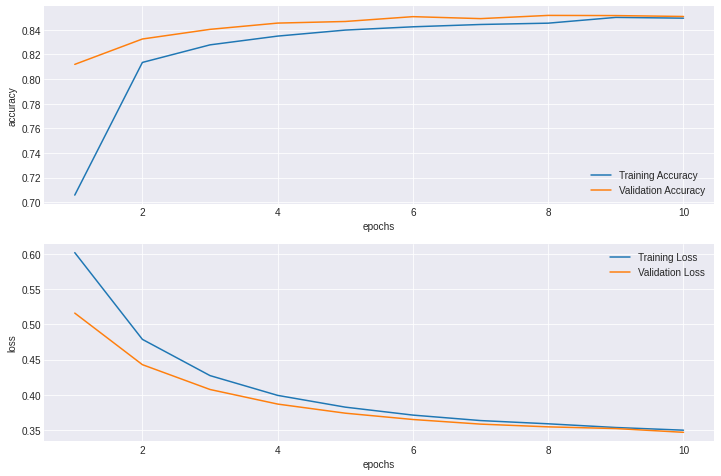

In [ ]:
performance_plot(history1)

## Experiment: 2 Adaptive Learning Rate



In [ ]:
#Referene: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
from official.nlp import optimization
epochs=1
batch_size=256
step_per_epoch=int(X_tr.shape[0]/batch_size)
total_steps=step_per_epoch*epochs
warmup_steps= int(0.1 * total_steps)
initial_lr=5e-2


In [ ]:
exp2_opt=optimization.create_optimizer(init_lr=initial_lr,
                                       num_warmup_steps=warmup_steps,
                                       num_train_steps=total_steps,
                                       optimizer_type='adamw')

In [ ]:
model.compile(optimizer=exp2_opt,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

print(model.summary())
history2=model.fit(X_tr,y_tr,epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val,y_val),
                    verbose=1)
#print('\n Training Evaluation')
#print(model.evaluate(Xtr,ytr))
print('\n Test Evaluation')
print(model.evaluate(Xtest,ytest))
test_prediction=model.predict(Xtest)
predicted_test=[1 if x>0.5 else 0 for x in test_prediction.flatten()]
print(classification_report(ytest,predicted_test))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                          
                                                                                                  
 keras_layer_1 (KerasLayer)     {'encoder_outputs':  66362880    ['keras_layer[0][0]',        

 Using entire dataset, with lr=0.01

# References:

1.   [Amazon Fine Foods Dataset](https://snap.stanford.edu/data/web-FineFoods.html)
2.   [Newbedev-pandas-if-else](#https://newbedev.com/how-to-use-if-else-in-pandas-dataframe-code-example)
3.   [Tensorflow-Tutorials](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)
4.    [What is BERT? | Deep Learning Tutorial 46 (Tensorflow, Keras & Python)](https://youtu.be/7kLi8u2dJz0)

5. [Text Classification Using BERT & Tensorflow | Deep Learning Tutorial 47 (Tensorflow, Keras & Python)](https://www.youtube.com/watch?v=hOCDJyZ6quA)